# U-Net using Pytorch

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. 

The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction.

In our case we will be using a U-Net to distinguish between shapes in an image created using helper functions.

## Initial Setup

Firstly, we need to import the required modules so that we can create and manipulate the images and visualize it in plots.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

### Image Plotting

The functions below allow us to visualize the images and plot the results side by side to allow for better clarity. There is also a masking function to color the distinct objects when they are displayed to show the results of the segmentation.

In [2]:
# Plotting the images
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

# Plotting the original image, ground truth and prediction results side by side
from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

# Plotting the error
import itertools
def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

# Masking the prediction results to disply the outcome of segmentation
def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

### Data Generation

The code below is used to generate the original dataset as well as the test data for the U-Net. We create images that contain various shapes at random locations.

In [3]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

We use `generate_random_data` to create some samples. Then,we use the helper functions previously defined to print them along with their target masks.

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


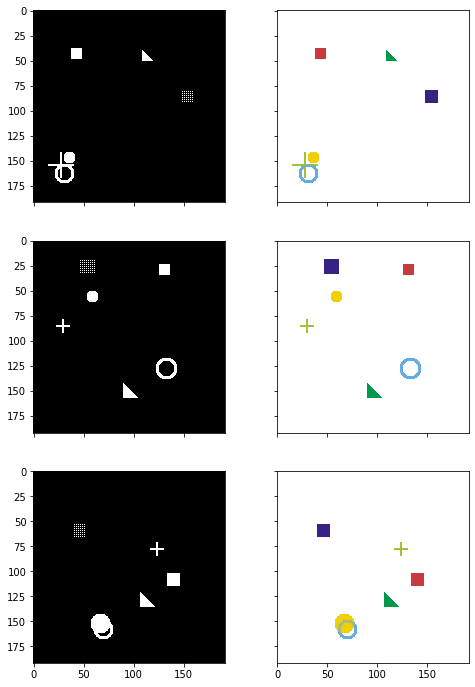

In [4]:
# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
plot_side_by_side([input_images_rgb, target_masks_rgb])

## U-Net using PyTorch

We start by importing all the pytorch modules that we will need to create the U-Net.

In [5]:
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch.optim as optim
from torch.optim import lr_scheduler

### Data Setup

Next, we create the training and validation sets and transform them to make them suitable inputs to the U-Net. In this case we create 2000 images for the training set and 200 for the validation set.

In [6]:
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

We need to create a function to reverse the transformation and display the image form of the array. This will allow us to view the original image as well as convert the output of the net to image form.

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 1.0 0.022681206 0.14888507
0.0 1.0 0.0046871384 0.06830193


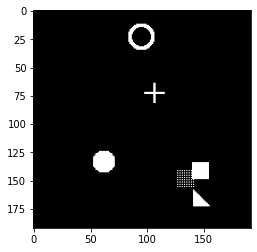

In [7]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

### Network Creation

We create a helper function to create a Sequential double convolution layer as we will need to do so a few times to create the U-Net.

In [8]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

The following is the code to create the U-Net structure using the PyTorch Neural Net module -

In [9]:
class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

If a GPU is available we train on that so we can to reduce the training time.

We call the function `UNet` to create a U-Net and print the summary of the model for verification.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training

To train the model we must first decide on a metric to evaluate it on so that we can check how good the model is. The loss is calculated in the `calc_loss` function and stored as a metric.

In [11]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = nn.functional.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

Next, we create the training loop. We will iterate over each epoch and update the model with the best weights i.e. the weights that result in the least amount of loss. After going through all the epochs we are left with the model that has the lowest loss.

In [26]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            if phase == 'train':
              scheduler.step()

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We will now create and train a U-Net while taking note of the time taken for each epoch iteration. The optimizer is used is the Adam optimizer.

In [27]:
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

cuda:0


In [28]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
LR 0.0001
train: bce: 0.191529, dice: 0.986695, loss: 0.589112
val: bce: 0.028165, dice: 0.888280, loss: 0.458223
saving best model
0m 32s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.025071, dice: 0.759078, loss: 0.392074
val: bce: 0.029232, dice: 0.627540, loss: 0.328386
saving best model
0m 32s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.022679, dice: 0.534846, loss: 0.278763
val: bce: 0.015588, dice: 0.443004, loss: 0.229296
saving best model
0m 32s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.015368, dice: 0.411958, loss: 0.213663
val: bce: 0.012238, dice: 0.372147, loss: 0.192192
saving best model
0m 32s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.014661, dice: 0.348760, loss: 0.181710
val: bce: 0.011523, dice: 0.295779, loss: 0.153651
saving best model
0m 32s
Epoch 5/39
----------
LR 0.0001
val: bce: 0.010064, dice: 0.208159, loss: 0.109112
saving best model
0m 32s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.010448, dice: 0.201434, loss: 0.105941
va

## Testing

The test dataset is created in the same manner as the training and validation sets. We create a `DataLoader` for it and pass it to the model for prediction. Then, we use the helper functions defined earlier to display the original image, the target mask and the prediction side by side.

(3, 6, 192, 192)


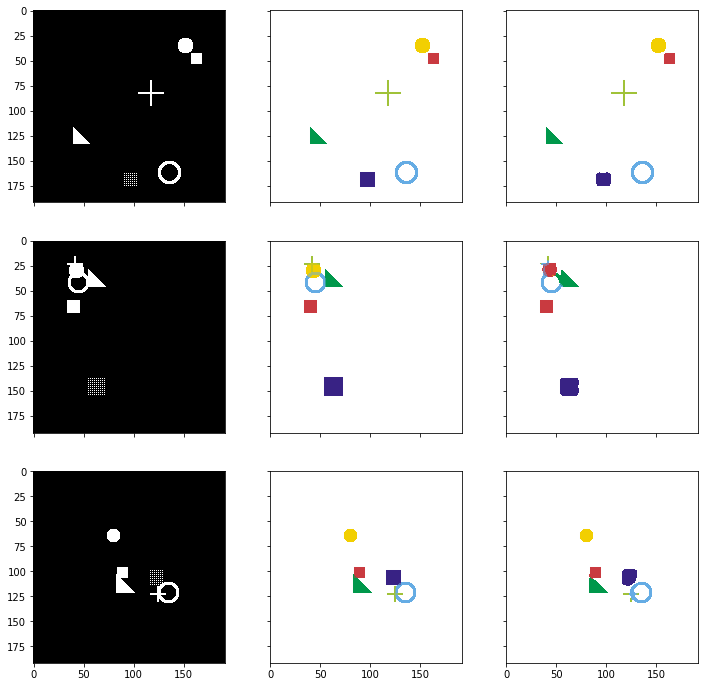

In [29]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

Thus we are able to realize a U-Net using Pytorch.

# References

1. [Naoto Usuyama's implementation of U-Net using PyTorch](https://libraries.io/github/usuyama)
2. [Blog Post: UNet by Heet Sankesara](https://towardsdatascience.com/u-net-b229b32b4a71)
3. [Wikipedia Page on U-Net](https://en.wikipedia.org/wiki/U-Net)